# LOVE19 ESSD - Horizontal Data Example

Here we image a submeso structure using the DTS, demonstrating the novelty and importance of these data for the atmospheric sciences community.

- This script assumes it is located inside a directory with the same architecture as the ESSD repository
- The script demonstrates the use of the horizontal FODS elements of LOVE19: inner rectangle, NS-transect, FODS air temperature and wind speed on the 12m tower, CSAT fluxes from the 12m tower.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import pyfocs

# OS interaction
import os

# import plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter
import datetime
import seaborn as sns


/Users/lapok/opt/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#3498db", "#FFBF00", "#95a5a6", "#34495e", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

pd.plotting.register_matplotlib_converters()

# Directories

The below command should return the path to the LOVE19 ESSD repository `example-scripts` repository.

In [3]:
dir_notebook = os.getcwd()
dir_essd = os.path.abspath(os.path.relpath(dir_notebook, 'ESSD-repository'))
dir_essd

'/Volumes/darkmix_raid/darkmix_archive/darkmix_data_2019/field/LOVE/ESSD-repository'

In [4]:
# Met data
dir_csat_flux = os.path.join(dir_essd, 'CSAT fluxes')
dir_aws = os.path.join(dir_essd, 'AWS')

# Figures
dir_print = os.path.join(dir_essd, 'figures')

# DTS data (North Simba and Outer Array)
dir_ns_final = os.path.join(dir_essd, 'FODS', 'FODS-cross')
dir_oa_final = os.path.join(dir_essd, 'FODS', 'outer-array')
dir_heating = os.path.join(dir_essd, 'FODS', 'heating-rates')

Start with v3, which includes the updates from correcting the Mane's mapping.

In [5]:
# To get the height above ground level and not the
# height relative to the fixed reference point, 
# we need to account for the local topography using these
# values
z_tb = 1.448183004 + 0.1
z_fc = 0.342392171 + 1.61

# Gather Data

## CSAT Data

In [6]:
os.chdir(dir_csat_flux)
csat_1min = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
csat_1min_qc = xr.open_dataset('LOVE19_CSAT_1min_qaqc.v2020-12-03.nc')
csat_10min_qc = xr.open_dataset('LOVE19_CSAT_10min_qaqc.v2020-12-03.nc')

csat_names = ['0.5m', '1m', '4m', '12m']

csat_1min.coords['names'] = (('z'), csat_names)
csat_1min = csat_1min.swap_dims({'z': 'names'})

csat_1min_qc.coords['names'] = (('z'), csat_names)
csat_1min_qc = csat_1min_qc.swap_dims({'z': 'names'})

# Adjust the CSAT heights now
csat_names = ['0.5m', '1m', '4m', '12m']

csat_1min.coords['names'] = (('z'), csat_names)
csat_1min = csat_1min.swap_dims({'z': 'names'})

# Actual recorded heights
csat_heights = {'LOVE19_CSATs_00p5m': -1.04911579,
                'LOVE19_CSATs_01m': -0.308039694,
                'LOVE19_CSATs_04m': 2.536769369,
                'LOVE19_CSATs_12m': 10.43707809,}

# Adjust everything to the local height above ground.
for csat in csat_heights:
    csat_heights[csat] = csat_heights[csat] + z_tb

## AWS

In [7]:
os.chdir(dir_aws)
aws = xr.open_dataset('AWS_Voi_1min.nc')

## DTS Data

In [8]:
# North Simba
ds_ns_hot = xr.open_mfdataset(os.path.join(dir_ns_final, '*2019-07-22*_heated.nc'), combine='by_coords')
ds_ns_cold = xr.open_mfdataset(os.path.join(dir_ns_final, '*2019-07-22*_unheated.nc'), combine='by_coords')

# Outer array - Matrix Inversion Calibration
ds_p1 = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-22*_p1.nc'), combine='by_coords')
ds_ss_hot = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-22*_heated.nc'), combine='by_coords')
ds_ss_cold = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-22*_unheated.nc'), combine='by_coords')

### Prune to just the pre-morning period and load into memory for ease of computation

In [9]:
ds_ns_hot = ds_ns_hot.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ns_cold = ds_ns_cold.sel(time=slice(None, '2019-07-22 06:00')).load()

ds_p1 = ds_p1.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ss_hot = ds_ss_hot.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ss_cold = ds_ss_cold.sel(time=slice(None, '2019-07-22 06:00')).load()

### Tower temperature and wind speed

In [10]:
ds_tower_cold = ds_ns_cold.where((ds_ns_cold.unheated == 'tower'), drop=True)
ds_tower_hot = ds_ns_hot.where((ds_ns_hot.heated == 'tower'), drop=True)

In [11]:
# Fiber radius in meters
rad = 1.32 / 2 * 10**(-3)
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 5 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

p = 4.5
params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small, so the exact value here plays a tertiary role.
    'density': density_per_m_fiber
}

aws_sub = aws.reindex_like(ds_tower_cold.time, method='nearest')

tower_wind_speed  = pyfocs.wind_speed.calculate(
    ds_tower_hot.cal_temp + 273.15,
    ds_tower_cold.cal_temp + 273.15,
    p,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params)

### Outer Array wind speed

In [12]:
os.chdir(dir_heating)
# Open the estimated heating rates and assign to the "hot" dataset
ds_or_heat = xr.open_dataset('outer-rectangle_heating-rates.nc')
ds_ss_hot['power'] = ds_or_heat.outer_rectangle

### Calculate Wind Speed

Here we need to include the fiber parameters as well as the longwave in and out. We use the van Ramshorst 2020 method for calculating wind speed.

In [13]:
# Fiber radius in meters
rad = 1.04 / 2 * 10**(-3)
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 3 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small, so the exact value here plays a tertiary role.
    'density': density_per_m_fiber
}

aws_sub = aws.reindex_like(ds_ss_hot.time, method='nearest')

oa_wind_speed = pyfocs.wind_speed.calculate(
    ds_ss_hot.cal_temp + 273.13,
    ds_ss_cold.cal_temp + 273.13,
    ds_ss_hot.power / 2,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params
)

# Break into horizontal wind speed components, based on what direction is orthogonal to the fiber.
ns_components = ['OR_SE', 'OR_NW']
logic = [oa_wind_speed.unheated == l for l in ns_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ns = oa_wind_speed.where(logic, drop=True)#.rolling(xyz=10, center=True).mean()

ew_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [oa_wind_speed.unheated == l for l in ew_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ew = oa_wind_speed.where(logic, drop=True)#.rolling(xyz=10, center=True).mean()

### The North-South transect

(originally named the mane)

In [14]:
ds_mane = ds_ns_cold.where((ds_ns_cold.unheated == 'mane_south') | (ds_ns_cold.unheated == 'mane_north'), drop=True)

# Components of the Figure

Build these independently from each other to allow better testing of each without having to adjust and build the massive figure.

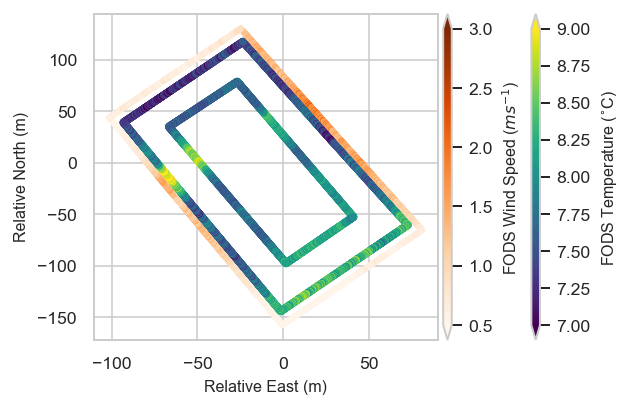

In [15]:
fig = plt.figure(figsize=(4, 3))

spec = fig.add_gridspec(ncols=4,
                        nrows=1,
                        width_ratios=[1, 0.025, 0.2, 0.025],
                        hspace=0.18, wspace=0.05,
                        )
ax_u_cbar = fig.add_subplot(spec[0, 1])
ax_t_cbar = fig.add_subplot(spec[0, 3])
ax = fig.add_subplot(spec[0, 0])

t1_before = '2019-07-22 03:31:00'
t2_before = '2019-07-22 03:31:20'
tslice_before = slice(t1_before, t2_before)

vmin = 7
vmax = 9

ds_plot = ds_p1.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_before).mean(dim='time')
im_t = ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x * 1.1 + 1, ds_plot.y * 1.1 + 1, 5, ds_plot, cmap='Oranges', vmin=0.5, vmax=3)

ds_plot = wind_speed_ns.sel(time=tslice_before).mean(dim='time')
im_u = ax.scatter(ds_plot.x * 1.1 + 1, ds_plot.y * 1.1 + 1, 5, ds_plot, cmap='Oranges', vmin=0.5, vmax=3)

ax.set_xlabel('Relative East (m)')
ax.set_ylabel('Relative North (m)')

plt.colorbar(im_t, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('FODS Temperature ($^{\circ}$C)')

plt.colorbar(im_u, cax=ax_u_cbar, extend='both')
ax_u_cbar.set_ylabel('FODS Wind Speed ($ms^{-1}$)')

os.chdir(dir_print)
fig.savefig('ESSD.processing-example-final.png', dpi=300, bbox_inches='tight')
fig.savefig('ESSD.processing-example-final.pdf', bbox_inches='tight')
fig.savefig('ESSD.processing-example-final.eps', bbox_inches='tight')

Text(0.5, 1.0, 'c) 2019-07-22 03:32:20')

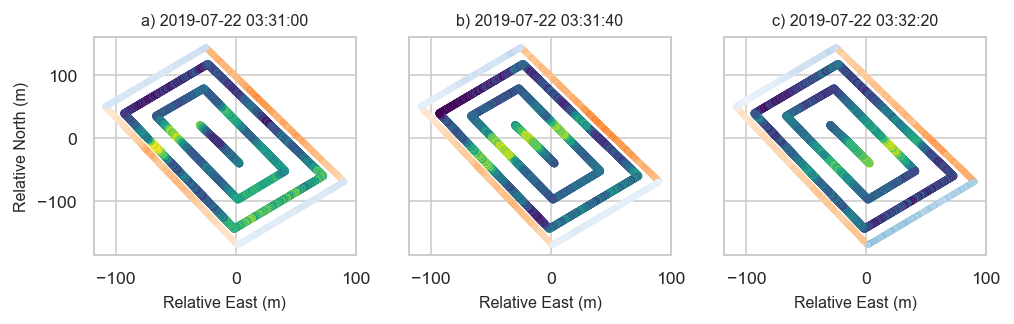

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True)

t1_before = '2019-07-22 03:31:00'
t2_before = '2019-07-22 03:31:20'
tslice_before = slice(t1_before, t2_before)

t1_during = '2019-07-22 03:31:40'
t2_during = '2019-07-22 03:32:00'
tslice_during = slice(t1_during, t2_during)

t1_after = '2019-07-22 03:32:20'
t2_after = '2019-07-22 03:32:40'
tslice_after = slice(t1_after, t2_after)

vmin = 7
vmax = 9

# After
ax = axes[0]
ds_plot = ds_p1.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Oranges', vmin=0, vmax=4)

ds_plot = wind_speed_ns.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Blues', vmin=0, vmax=4)

ax.set_xlabel('Relative East (m)')
ax.set_ylabel('Relative North (m)')
ax.set_title('a) ' + str(pd.Timestamp(t1_before)))

# During
ax = axes[1]
ds_plot = ds_p1.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Oranges', vmin=0, vmax=4)

ds_plot = wind_speed_ns.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Blues', vmin=0, vmax=4)

ax.set_xlabel('Relative East (m)')
ax.set_title('b) ' + str(pd.Timestamp(t1_during)))

# After
ax = axes[2]
ds_plot = ds_p1.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Oranges', vmin=0, vmax=4)

ds_plot = wind_speed_ns.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='Blues', vmin=0, vmax=4)

ax.set_xlabel('Relative East (m)')
ax.set_title('c) ' + str(pd.Timestamp(t1_after)))

## Tower time-height cross sections

Text(0, 0.5, 'FODS Wind Speed $(m^{-1})$')

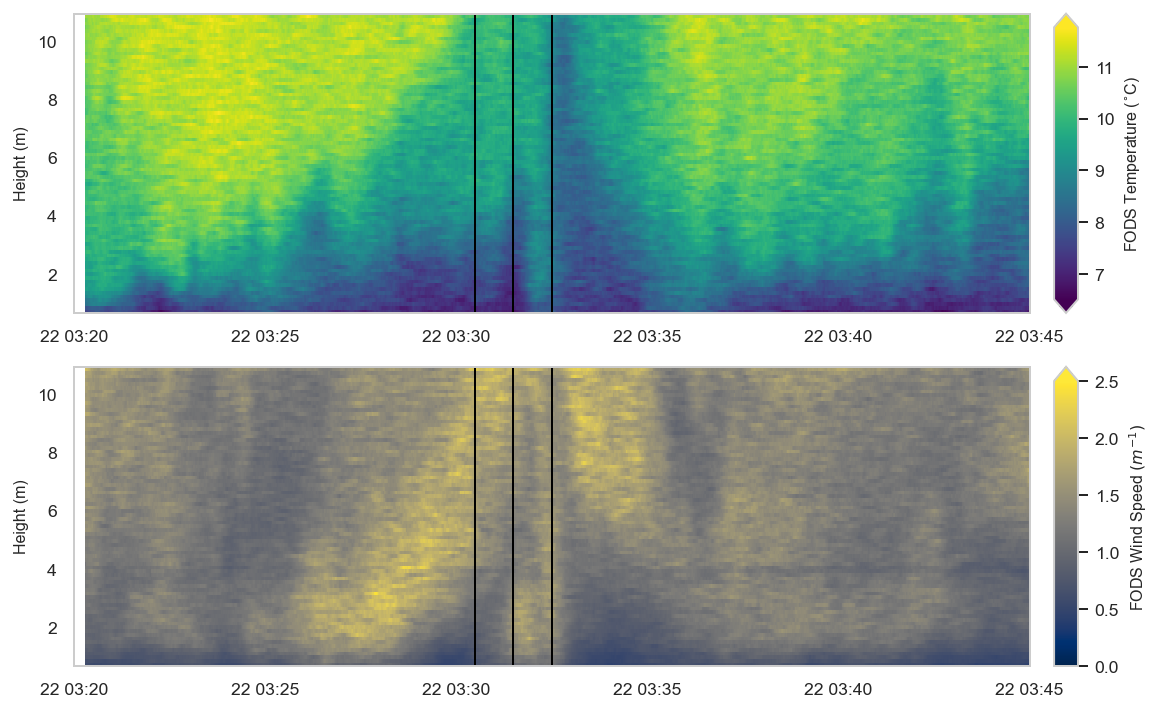

In [17]:
# Time variables
t1 = '2019-07-22 03:20:00'
t2 = '2019-07-22 03:45:00'
tslice = slice(t1, t2)

tbefore = '2019-07-22 03:30:30'
tduring = '2019-07-22 03:31:30'
tafter = '2019-07-22 03:32:30'

# Build the figure
fig = plt.figure(figsize=(9, 6),)

spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_ew_cbar = fig.add_subplot(spec[1, 1])
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])
ax_wind = fig.add_subplot(spec[1, 0])

# The temperature plot
ax = ax_temp
ds_plot = ds_tower_cold.sel(time=tslice)
dt = pd.Timedelta(ds_plot.dt).seconds
ds_plot = ds_plot.rolling(time=20 // dt).mean()
im = ax.pcolormesh(
    ds_plot.time,
    ds_plot.z + z_tb,
    ds_plot.cal_temp.T,
    cmap='viridis',
    shading='nearest',
)
ax.axvline([tbefore], color='k', linewidth=1)
ax.axvline([tduring], color='k', linewidth=1)
ax.axvline([tafter], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('FODS Temperature ($^{\circ}$C)')

# The horizontal wind speed plot
ax = ax_wind
ds_plot = tower_wind_speed.sel(time=tslice)
ds_plot = ds_plot.rolling(time=20 // dt).mean()
im = ax.pcolormesh(
    ds_plot.time, 
    ds_plot.z + z_tb,
    ds_plot.T,
    cmap='cividis',
    vmin=0.,
    vmax=2.5,
    shading='nearest'
)
ax.axvline([tbefore], color='k', linewidth=1)
ax.axvline([tduring], color='k', linewidth=1)
ax.axvline([tafter], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
plt.colorbar(im, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('FODS Wind Speed $(m^{-1})$')



#### For reference, the vertical gradients in $T$ and $U$

The DTS data is very noisy, so we use rolling block differences when computing the gradient. This is a function in pyfocs.

In [18]:
# Time variables
t1 = '2019-07-22 03:20:00'
t2 = '2019-07-22 03:45:00'
tslice = slice(t1, t2)

tbefore = '2019-07-22 03:30:30'
tduring = '2019-07-22 03:31:30'
tafter = '2019-07-22 03:32:30'

# Block gradients with a step size of 1.5m
indexer = 'z'
step_size = 0.127
window_size = np.round(1.5 / step_size).astype('int')

# Build the figure
fig = plt.figure(figsize=(9, 6),)

spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_ew_cbar = fig.add_subplot(spec[1, 1])
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])
ax_wind = fig.add_subplot(spec[1, 0])

# The temperature gardient plot
ax = ax_temp
ds_plot = ds_tower_cold.sel(time=tslice).swap_dims({'xyz': 'z'})
dt = pd.Timedelta(ds_plot.dt).seconds
ds_plot = ds_plot.rolling(time=10//dt).mean()
ds_plot = pyfocs.stats.block_diff(ds_plot.cal_temp, indexer, window_size, step_size)
im = ax.pcolormesh(
    ds_plot.time,
    ds_plot.z + z_tb,
    ds_plot.T,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    shading='nearest',
)
ax.axvline([tbefore], color='k', linewidth=1)
ax.axvline([tduring], color='k', linewidth=1)
ax.axvline([tafter], color='k', linewidth=1)
ax.set_title('Temperature gradient, block diff of 1.5m, 10s rolling avg')
ax.set_ylabel('Height (m)')
ax.set_xticklabels([])
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel(r'$\frac{dT}{dz}~ (\frac{^{\circ}C}{m})$')

# The horizontal wind speed plot
ax = ax_wind
ds_plot = tower_wind_speed.sel(time=tslice).swap_dims({'xyz': 'z'})
ds_plot = ds_plot.rolling(time=10//dt).mean()
ds_plot = pyfocs.stats.block_diff(ds_plot, indexer, window_size, step_size)
im = ax.pcolormesh(
    ds_plot.time,
    ds_plot.z + z_tb,
    ds_plot.T,
    cmap='RdBu_r',
    vmin=-0.5,
    vmax=0.5,
    shading='nearest',
)
ax.axvline([tbefore], color='k', linewidth=1)
ax.axvline([tduring], color='k', linewidth=1)
ax.axvline([tafter], color='k', linewidth=1)
ax.set_title('Wind speed gradient, block diff of 1.5m, 10s rolling avg')
ax.set_ylabel('Height (m)')
plt.colorbar(im, cax=ax_ew_cbar, extend='both')
ax_ew_cbar.set_ylabel(r'$\frac{dU}{dz}~(s^{-1})$')

Text(0, 0.5, '$\\frac{dU}{dz}~(s^{-1})$')

## Vertical profiles of $T$ and $U$

Here I just experiment with how the profile evolves by plotting 30s averages over a slightly larger window. Purely for descriptive purposes in the ESSD text.

Note: the 5 * dLAF (~1m) smoothing through a spatial rolling average. The DTS data is too noisy to otherwise distinguish visually between profiles.

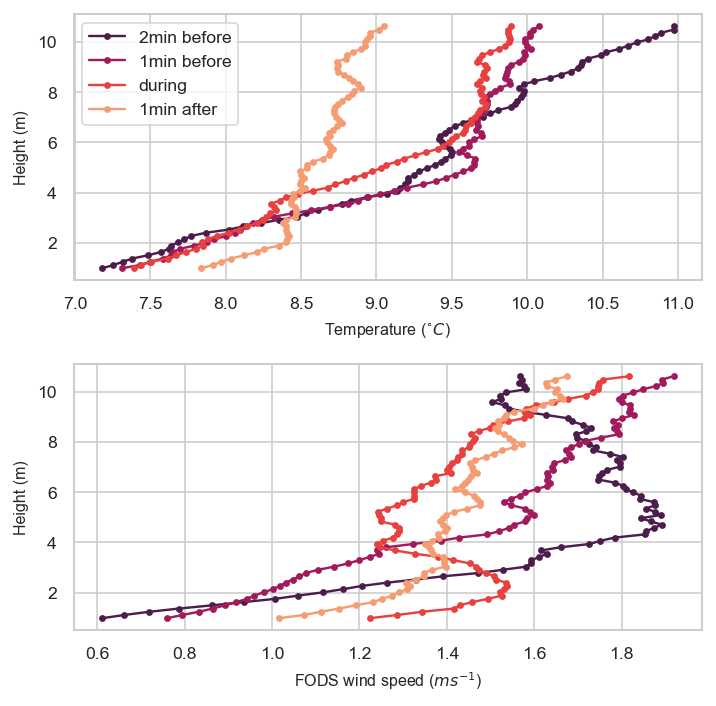

In [19]:
# Make a profile for each CSAT observation
t1 = '2019-07-22 03:29:00'
t2 = '2019-07-22 03:30:00'
tslice_2min_before = slice(t1, t2)

t1 = '2019-07-22 03:30:00'
t2 = '2019-07-22 03:31:00'
tslice_1min_before = slice(t1, t2)

t1 = '2019-07-22 03:31:00'
t2 = '2019-07-22 03:32:00'
tslice_during = slice(t1, t2)

t1 = '2019-07-22 03:32:00'
t2 = '2019-07-22 03:33:00'
tslice_after = slice(t1, t2)

tcolor = sns.color_palette('rocket', 4)

# Build the figure
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

ax = axes[0]
ds_plot = ds_tower_cold.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ax.plot(ds_plot.sel(time=tslice_2min_before).mean(dim='time').cal_temp, ds_plot.z + z_tb,
    label='2min before', marker='.', color=tcolor[0])
ax.plot(ds_plot.sel(time=tslice_1min_before).mean(dim='time').cal_temp, ds_plot.z + z_tb,
    label='1min before', marker='.', color=tcolor[1])
ax.plot(ds_plot.sel(time=tslice_during).mean(dim='time').cal_temp, ds_plot.z + z_tb,
    label='during', marker='.', color=tcolor[2])
ax.plot(ds_plot.sel(time=tslice_after).mean(dim='time').cal_temp, ds_plot.z + z_tb, 
    label='1min after', marker='.', color=tcolor[3])

ax.legend()
ax.set_ylabel('Height (m)')
ax.set_xlabel('Temperature ($^{\circ} C$)')

ax = axes[1]
ds_plot = tower_wind_speed.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ax.plot(
    ds_plot.sel(time=tslice_2min_before).mean(dim='time'), ds_plot.z + z_tb, label='2min before',
    marker='.', color=tcolor[0])
ax.plot(ds_plot.sel(time=tslice_1min_before).mean(dim='time'), ds_plot.z + z_tb,
        marker='.', color=tcolor[1])
ax.plot(ds_plot.sel(time=tslice_during).mean(dim='time'), ds_plot.z + z_tb,
        marker='.', color=tcolor[2])
ax.plot(ds_plot.sel(time=tslice_after).mean(dim='time'), ds_plot.z + z_tb,
        marker='.', color=tcolor[3])

ax.set_ylabel('Height (m)')
ax.set_xlabel('FODS wind speed ($m s^{-1} $)')
fig.tight_layout()

### Now to make the figure that will appear in the paper.

In [20]:
tbeg = '2019-07-22 03:30:30'
tend = '2019-07-22 03:32'
t_sm = '2019-07-22 03:31'
tresample = '30s'

# Build the figure
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

ax = axes[0]
ds_plot = ds_tower_cold.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))
tcolor = sns.color_palette('mako', len(ds_plot.time))

for n, t in enumerate(ds_plot.time):
    if pd.Timestamp(t.values) == pd.Timestamp(t_sm):
        n_sm = n
    tl = pd.Timestamp(t.values).strftime('%H:%M:%S')
    ax.plot(ds_plot.sel(time=t.values).cal_temp, ds_plot.z + z_tb, marker='.', color=tcolor[n], label=tl)
ax.legend()

ax.set_ylabel('Height (m)')
ax.set_xlabel('Temperature ($^{\circ} C$)')

ax = axes[1]
ds_plot = tower_wind_speed.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))

for n, t in enumerate(ds_plot.time):
    ax.plot(
        ds_plot.sel(time=t), ds_plot.z + z_tb, marker='.', color=tcolor[n])

ax.set_ylabel('Height (m)')
ax.set_xlabel('FODS wind speed ($m s^{-1} $)')
fig.tight_layout()

## x-z cross sections along the NS transect and tower

Generally, the large color range necessary to represent the tower makes these plots less useful to interpret.

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharey=True)
t1_before = '2019-07-22 03:31:00'
t2_before = '2019-07-22 03:31:20'
tslice_before = slice(t1_before, t2_before)

t1_during = '2019-07-22 03:31:40'
t2_during = '2019-07-22 03:32:00'
tslice_during = slice(t1_during, t2_during)

t1_after = '2019-07-22 03:32:20'
t2_after = '2019-07-22 03:32:40'
tslice_after = slice(t1_after, t2_after)


vmin = 7
vmax = 10

# After
ax = axes[0]
ds_plot = ds_tower_cold.sel(time=tslice_before).mean(dim='time')
ds_plot = ds_plot.swap_dims({'xyz': 'z'}).interp(z=np.linspace(ds_plot.z.min(), ds_plot.z.max(), 200))
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ns_cold.sel(time=tslice_before).mean(dim='time').where((ds_ns_cold.unheated == 'mane_south') | (ds_ns_cold.unheated == 'mane_north'), drop=True)
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_ylim(-1.5, 8)

ax.set_xlabel('Relative North (m)')
ax.set_ylabel('Relative Height (m)')
ax.set_title('a) ' + str(pd.Timestamp(t1_before).round('1min')))

# During
ax = axes[1]
ds_plot = ds_tower_cold.sel(time=tslice_during).mean(dim='time')
ds_plot = ds_plot.swap_dims({'xyz': 'z'}).interp(z=np.linspace(ds_plot.z.min(), ds_plot.z.max(), 200))
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ns_cold.sel(time=tslice_during).mean(dim='time').where((ds_ns_cold.unheated == 'mane_south') | (ds_ns_cold.unheated == 'mane_north'), drop=True)
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_ylim(-1.5, 8)

ax.set_xlabel('Relative North (m)')
ax.set_title('b) ' + str(pd.Timestamp(t1_during).round('1min')))

# After
ax = axes[2]
ds_plot = ds_tower_cold.sel(time=tslice_after).mean(dim='time')
ds_plot = ds_plot.swap_dims({'xyz': 'z'}).interp(z=np.linspace(ds_plot.z.min(), ds_plot.z.max(), 200))
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ns_cold.sel(time=tslice_after).mean(dim='time').where((ds_ns_cold.unheated == 'mane_south') | (ds_ns_cold.unheated == 'mane_north'), drop=True)
ax.scatter(ds_plot.y, ds_plot.z, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_ylim(-1.5, 8)

ax.set_xlabel('Relative North (m)')
ax.set_title('c) ' + str(pd.Timestamp(t1_after).round('1min')))

Text(0.5, 1.0, 'c) 2019-07-22 03:32:00')

# Outer Array Time-Space Cross Section (Wind speed and Temperature)

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_context('paper')

fig = plt.figure(figsize=(6, 4),)

spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_ew_cbar = fig.add_subplot(spec[1, 1])
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])
ax_wind = fig.add_subplot(spec[1, 0])

ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_NE2') | (ds_ss_cold.unheated=='OR_NE1'),
    drop=True).rolling(time=5, center=True).mean().sel(time=tslice).rolling(xyz=6, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_NE1') | (wind_speed_ew.unheated=='OR_NE2'),
    drop=True).sel(time=tslice)
ds_wind = ds_wind.sortby(ds_wind.y)

im = ax_temp.pcolormesh(
    ds_temp.time,
    ds_temp.y,
    ds_temp.cal_temp.T.values,
    cmap='viridis',
    vmin=7,
    vmax=9,
    shading='nearest'
)
ax_temp.set_ylabel('Relative Northing (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
ax_temp.set_title('a) Distributed Temperature', loc='left')
ax_temp.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax_temp,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# Wind speed along the outer rectangle
im = ax_wind.pcolormesh(
    ds_wind.time,
    ds_wind.y,
    ds_wind.values,
    cmap='cividis',
    vmin=0,
    vmax=2,
    shading='nearest',
)
ax_wind.set_title('b) Wind Speed', loc='left')
plt.colorbar(im, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('Wind Speed (m/s)')
ax_wind.set_ylabel('Relative Northing (m)')

for ax in fig.get_axes():
    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(30.)


In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_context('paper')

fig = plt.figure(figsize=(9, 4),)

spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_ew_cbar = fig.add_subplot(spec[1, 1])
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])
ax_wind = fig.add_subplot(spec[1, 0])

ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_SW2') | (ds_ss_cold.unheated=='OR_SW1'),
    drop=True).sel(time=tslice)
ds_temp = ds_temp.sortby(ds_temp.y)

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_SW1') | (wind_speed_ew.unheated=='OR_SW2'),
    drop=True).sel(time=tslice)
ds_wind = ds_wind.sortby(ds_wind.y)

im = ax_temp.pcolormesh(
    ds_temp.time,
    ds_temp.y,
    ds_temp.cal_temp.T.values,
    cmap='viridis',
    vmin=7,
    vmax=9,
    shading='nearest'
)
ax_temp.set_ylabel('Relative Northing (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
ax_temp.set_title('a) Distributed Temperature', loc='left')
ax_temp.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax_temp,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# Wind speed along the outer rectangle
im = ax_wind.pcolormesh(
    ds_wind.time,
    ds_wind.y,
    ds_wind.values,
    cmap='cividis',
    vmin=0,
    vmax=2,
    shading='nearest'
)
ax_wind.set_title('b) Wind Speed', loc='left')
plt.colorbar(im, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('Wind Speed $(m~s^{-1})$')
ax_wind.set_ylabel('Relative Northing (m)')

for ax in fig.get_axes():
    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(30.)


### Inner Array Time-Space Cross Section

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_context('paper')

fig = plt.figure(figsize=(9, 3),)

spec = fig.add_gridspec(ncols=2,
                        nrows=1,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])

ds_temp = ds_p1.where(
    (ds_p1.p1=='IR_NE2') | (ds_p1.p1=='IR_NE1'),
    drop=True).sel(time=tslice)
ds_temp = ds_temp.sortby(ds_temp.y)

im = ax_temp.pcolormesh(
    ds_temp.time,
    ds_temp.y,
    ds_temp.cal_temp.T.values,
    cmap='viridis',
    vmin=7.,
    vmax=9.5,
    shading='nearest',
)
ax_temp.set_ylabel('Relative Northing (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
ax_temp.set_title('a) Distributed Temperature', loc='left')

# Inset map
axins = inset_axes(
    ax_temp,
    width=0.5,
    height=0.5,
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

for ax in fig.get_axes():
    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(30.)


In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_context('paper')

temp_tslice = slice('2019-07-22 03:00', '2019-07-22 03:45')

fig = plt.figure(figsize=(9, 3),)

spec = fig.add_gridspec(ncols=2,
                        nrows=1,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_t_cbar = fig.add_subplot(spec[0, 1])
ax_temp = fig.add_subplot(spec[0, 0])

ds_temp = ds_mane.sel(time=temp_tslice)#.rolling(xyz=4, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)
im = ax_temp.pcolormesh(
    ds_temp.time,
    ds_temp.y,
    ds_temp.cal_temp.T.values,
    cmap='viridis',
    vmin=7.,
    vmax=10,
    shading='nearest',
)
ax_temp.set_ylabel('Relative Northing (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
ax_temp.set_title('a) Distributed Temperature', loc='left')

# Inset map
axins = inset_axes(
    ax_temp,
    width=0.5,
    height=0.5,
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

for ax in fig.get_axes():
    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(30.)


## CSAT

First the plot we will be using.

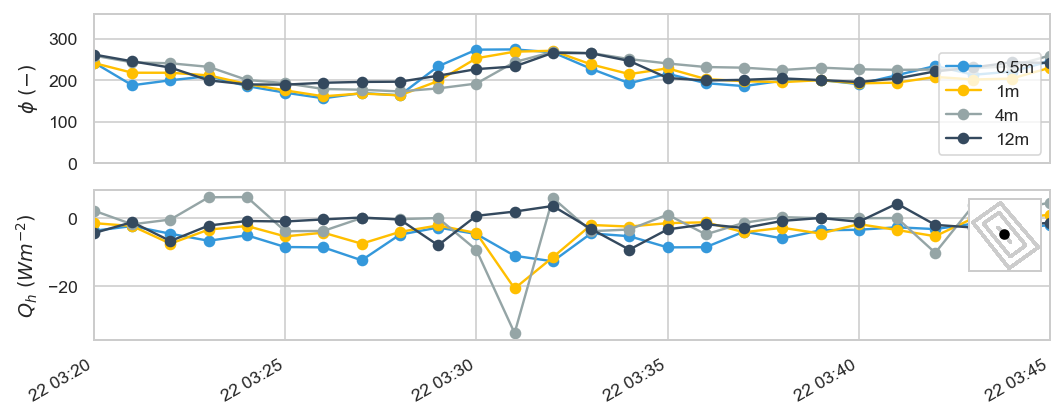

In [26]:
sns.set_context('paper')

# The friction velocity has some difficult to believe spikes during this period
# especially for the 12m CSAT. However, other stats, including the sensible heat
# flux are not obviously wrong. If you desire to filter for periods that are less
# high quality use the qc flags, e.g., 
# `.where(csat_1min_qc['wTs QAQC_flag'] < 2)`
ds_csat = csat_1min.sel(time=tslice)

fig = plt.figure(figsize=(9, 3),)

spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=[1, 0.025,],
                        hspace=0.18, wspace=0.05,
                        )
ax_phi = fig.add_subplot(spec[0, 0])
ax_h = fig.add_subplot(spec[1, 0])

for n in ds_csat.names:
    ax_phi.plot(ds_csat.time, ds_csat['phi'].sel(names=n.names), '-o', label=n.values)
ax_phi.set_ylabel('$\phi~ (-)$')
ax_phi.set_xticklabels([])
ax_phi.legend(loc='lower right')
ax_phi.set_xlim(tslice.start, tslice.stop)
ax_phi.set_ylim(0, 360)

for n in ds_csat.names:
    ax_h.plot(ds_csat.time, ds_csat['H'].sel(names=n.names), '-o', label=n.values)
ax_h.set_ylabel('$Q_h~ (Wm^{-2})$')
ax_h.set_xlim(tslice.start, tslice.stop)

# Inset map
axins = inset_axes(
    ax_h,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_tower_cold.x[0].values,
    ds_tower_cold.y[0].values,
    20,
    color='k',
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

for ax in fig.get_axes():
    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(30.)


### Additional CSAT quantities for context

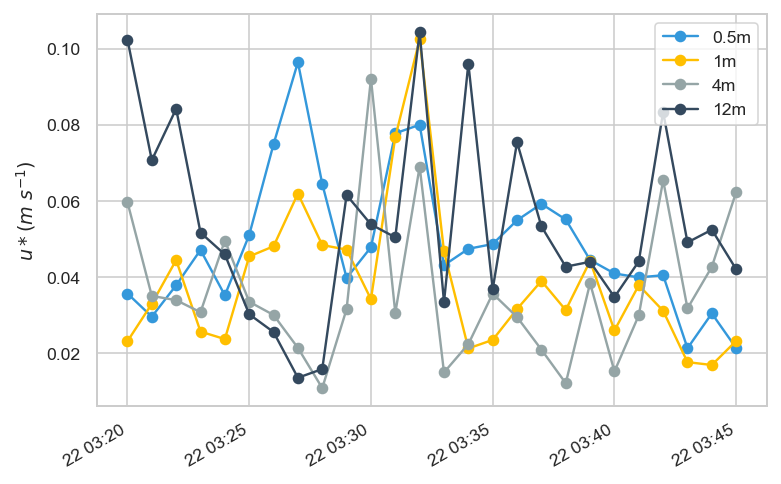

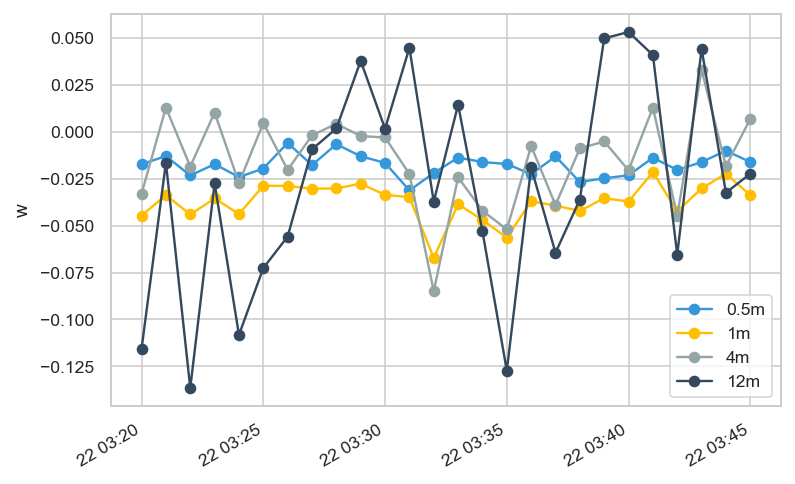

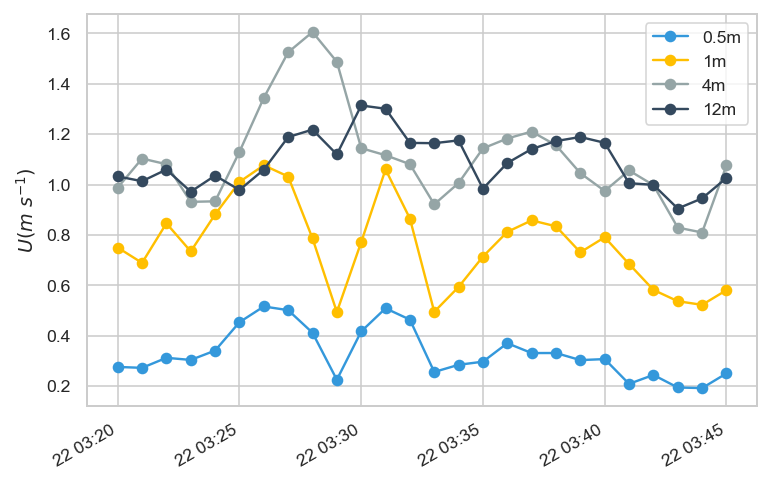

In [27]:
ds_csat = csat_1min.sel(time=tslice)

# Friction velocity
fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['u*'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('$u* (m~ s^{-1})$')
fig.autofmt_xdate()

# TKE
fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['TKE_mean'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('TKE')
fig.autofmt_xdate()

# Vertical wind
fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['w_mean_rot'].sel(names=n.names), '-o', label=n.values)
ax.set_ylabel('w')
ax.legend()
fig.autofmt_xdate()

# Horizontal wind
fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['U_scalar_mean_unrot'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('$U (m~ s^{-1})$')
fig.autofmt_xdate()

Generally, the upper CSATs struggled during this period. The submeso strucure seems to have two components, the sensible heat flux max at 0331 followed by the TKE/u* max at 0332 that had a realtively strong downdraft between 1 and 4m, but didn't really impact 0.5m.

The wind speed nose that occurs between ~0.8m and 4m is entirely missed by the 4m observations. This makes it look like it was a non-local generation mechanism, but I suspect the turbulence is partially mechanically generated at the interface between the wind speed nose of the submeso structure and the slower moving air of the environment above it. 

### The broader period

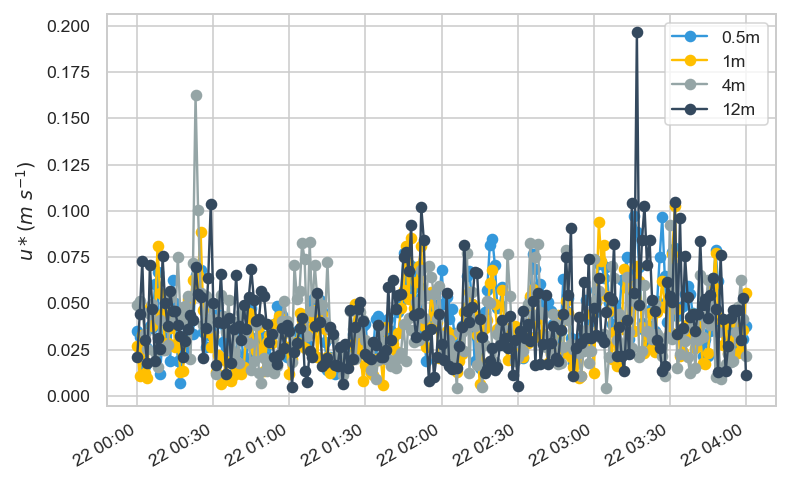

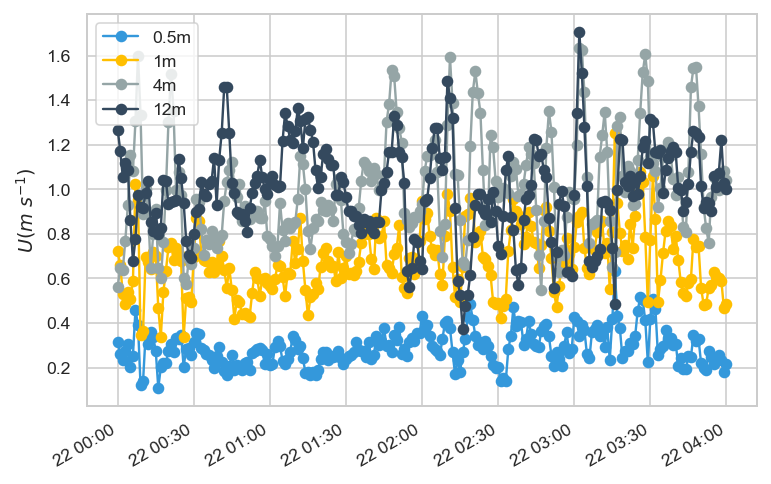

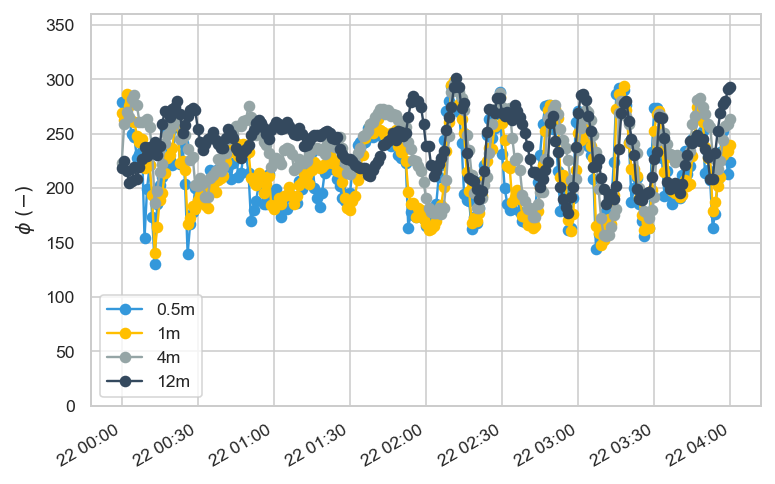

In [28]:
ds_csat = csat_1min.sel(time=slice('2019-7-22 00:00', '2019-07-22 04:00'))

fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['u*'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('$u* (m~ s^{-1})$')
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['U_scalar_mean_unrot'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('$U (m~ s^{-1})$')
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['phi'].sel(names=n.names), '-o', label=n.values)
ax.legend()
ax.set_ylabel('$\phi~ (-)$')
fig.autofmt_xdate()
ax.set_ylim(0, 360)

fig, ax = plt.subplots(1, 1)
for n in ds_csat.names:
    ax.plot(ds_csat.time, ds_csat['H'].sel(names=n.names), '-o', label=n.values)
ax.set_ylabel('$Q_h~ (Wm^{-2})$')
ax.legend()
ax.set_ylim(-35, 15)
fig.autofmt_xdate()

# Creating the combined figure

In [29]:
sns.set_context('paper', font_scale=0.8)

ValueError: 'y' not found in array dimensions ('xyz', 'time')

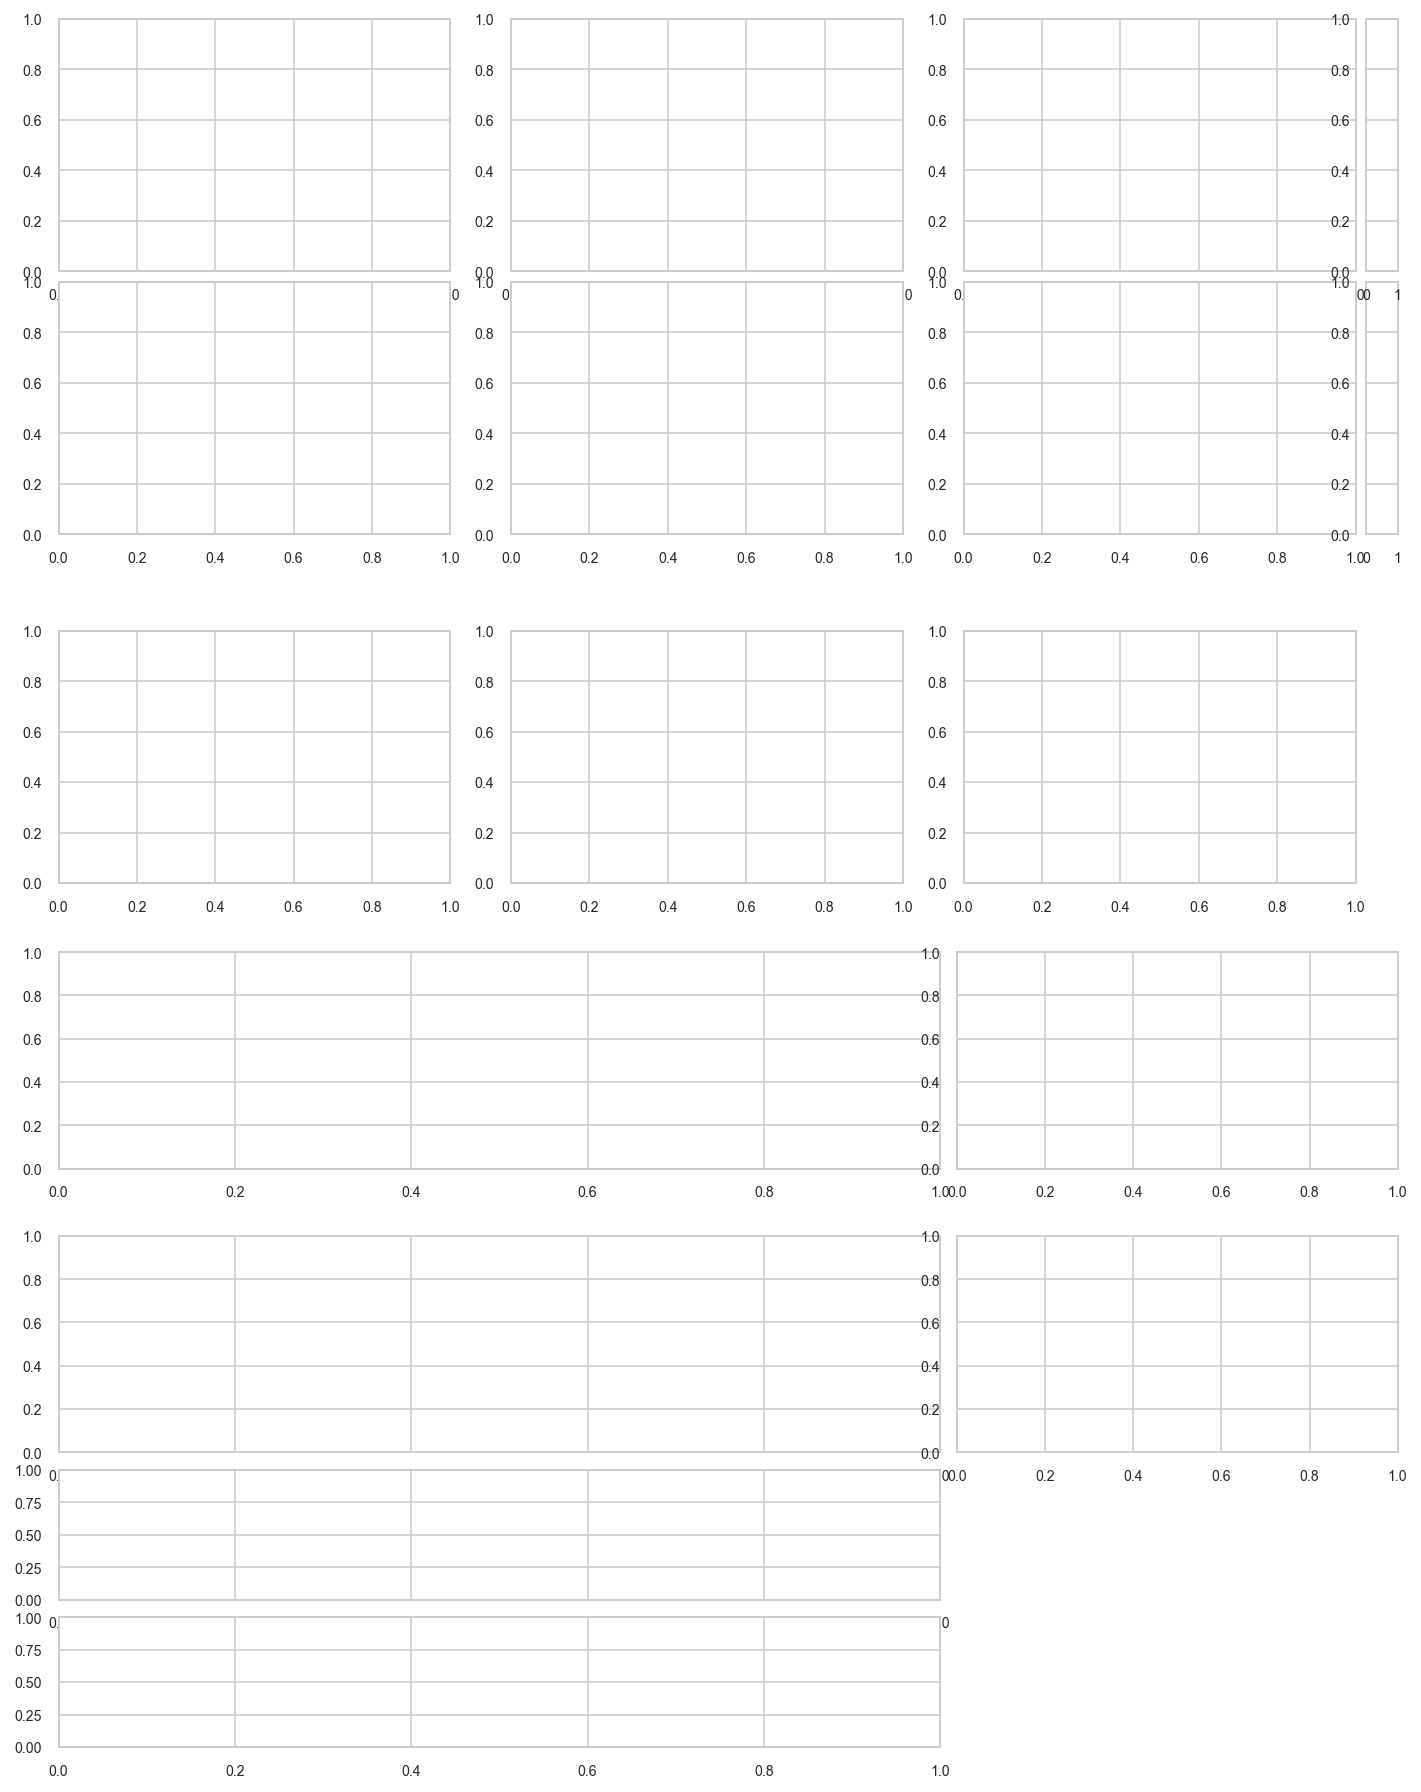

In [30]:
# Building the figure
fig = plt.figure(figsize=(12, 12))

spec = fig.add_gridspec(
    top=1,
    bottom=0.5,
    ncols=6,
    nrows=4,
    width_ratios=[1, 0.1, 1, 0.1, 1, 0.08,],
    height_ratios=[1, 1, 0.3, 1,],
    hspace=0.05, wspace=0.05,
)

ax_or_sw_t = fig.add_subplot(spec[0, 0])
ax_or_sw_u = fig.add_subplot(spec[1, 0])

ax_or_ne_t = fig.add_subplot(spec[0, 2])
ax_or_ne_u = fig.add_subplot(spec[1, 2])

ax_ir_ne = fig.add_subplot(spec[0, 4])
ax_ir_sw = fig.add_subplot(spec[1, 4])

ax_dts_before = fig.add_subplot(spec[3, 0])
ax_dts_during = fig.add_subplot(spec[3, 2])
ax_dts_after = fig.add_subplot(spec[3, 4])

ax_ew_cbar = fig.add_subplot(spec[1, -1])
ax_t_cbar = fig.add_subplot(spec[0, -1])

spec = fig.add_gridspec(
    top=0.46,
    bottom=0,
    ncols=2,
    nrows=5,
    width_ratios=[2, 1],
    height_ratios=[1, 0.15, 1, 0.6, 0.6],
    hspace=0.12, wspace=0.025,
)

ax_tower_t = fig.add_subplot(spec[0, 0])
ax_tower_u = fig.add_subplot(spec[2, 0])
ax_tower_u.get_shared_x_axes().join(ax_tower_u, ax_tower_t)

ax_tower_t_profiles = fig.add_subplot(spec[0, 1])
ax_tower_u_profiles = fig.add_subplot(spec[2, 1])
ax_tower_t_profiles.get_shared_y_axes().join(ax_tower_t_profiles, ax_tower_t, )
ax_tower_u_profiles.get_shared_y_axes().join(ax_tower_u_profiles, ax_tower_u, )

ax_csat_phi = fig.add_subplot(spec[3, 0])
ax_csat_h = fig.add_subplot(spec[4, 0])
ax_csat_phi.get_shared_x_axes().join(ax_csat_phi, ax_tower_t)
ax_csat_h.get_shared_x_axes().join(ax_csat_h, ax_tower_t)

# Plotting and data parameters
t1 = '2019-07-22 03:20:00'
t2 = '2019-07-22 03:45:00'
tslice = slice(t1, t2)

t1_before = '2019-07-22 03:31:00'
t2_before = '2019-07-22 03:31:20'
tslice_before = slice(t1_before, t2_before)

t1_during = '2019-07-22 03:31:40'
t2_during = '2019-07-22 03:32:00'
tslice_during = slice(t1_during, t2_during)

t1_after = '2019-07-22 03:32:20'
t2_after = '2019-07-22 03:32:40'
tslice_after = slice(t1_after, t2_after)

vmin = 6.5
vmax = 9.25

vmin_u = 0.
vmax_u = 2.

vmin_tower = 7
vmax_tower = 12


# ----------------------------------------------------------------------------------------------
# Outer Array - SW
ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_SW2') | (ds_ss_cold.unheated=='OR_SW1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)
ds_wind = ds_wind.rolling(time=5, center=True).mean()
ds_wind = ds_wind.rolling(y=10, center=True).mean()

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_NE1') | (wind_speed_ew.unheated=='OR_NE2'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_wind = ds_wind.swap_dims({'xyz': 'y'})
ds_wind = ds_wind.sortby(ds_wind.y)
ds_wind = ds_wind.rolling(time=5, center=True).mean()
ds_wind = ds_wind.rolling(y=10, center=True).mean()

ax = ax_or_sw_t
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='nearest')
ax.set_ylabel('Relative North (m)')
ax.text(0.025, 0.9, 'a)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

ax = ax_or_sw_u
im = ax.pcolormesh(
    ds_wind.time, ds_wind.y, ds_wind.values,
    cmap='cividis', vmin=vmin_u, vmax=vmax_u, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'd)', horizontalalignment='left', transform=ax.transAxes, color='w')
ax.set_ylabel('Relative North (m)')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# --------------------------------------------------------------------------------------------------
# Outer Array - SW
ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_NE2') | (ds_ss_cold.unheated=='OR_NE1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_NE1') | (wind_speed_ew.unheated=='OR_NE2'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_wind = ds_wind.sortby(ds_wind.y)

ax = ax_or_ne_t
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'b)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

ax = ax_or_ne_u
im = ax.pcolormesh(
    ds_wind.time, ds_wind.y, ds_wind.values,
    cmap='cividis', vmin=vmin_u, vmax=vmax_u, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'e)', horizontalalignment='left', transform=ax.transAxes, color='w')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# --------------------------------------------------------------------------------------------------
# Inner Array - NE
ds_temp = ds_p1.where(
    (ds_p1.p1=='IR_NE2') | (ds_p1.p1=='IR_NE1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ax = ax_ir_ne
im = ax.pcolormesh(ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
                cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'c)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# ------------------------------------------------------------------------------------------
# Inner Array - SW
ds_temp = ds_p1.where(
    (ds_p1.p1=='IR_SW2') | (ds_p1.p1=='IR_SW1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ax = ax_ir_sw
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'f)', horizontalalignment='left', transform=ax.transAxes)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# ------------------------------------------------------------------------------------------------------
# DTS snapshots
# Before
ax = ax_dts_before
ds_plot = ds_p1.sel(time=tslice_before).mean(dim='time')

ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_before).mean(dim='time')
im_t = ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_before).mean(dim='time')
im_ew = ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

ds_plot = wind_speed_ns.sel(time=tslice_before).mean(dim='time')
im_ns = ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

plt.colorbar(im_t, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
plt.colorbar(im_ew, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('U$\perp$ (m/s)')

ax.set_xlabel('Relative East (m)')
ax.set_ylabel('Relative North (m)')
ax.set_title('g) ' + pd.Timestamp(t1_before).strftime('%H:%M:%S'))

# During
ax = ax_dts_during

ds_plot = ds_p1.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

ds_plot = wind_speed_ns.sel(time=tslice_during).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 5, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

ax.set_xlabel('Relative East (m)')
ax.set_yticklabels([])
ax.set_title('h) ' + pd.Timestamp(t1_during).strftime('%H:%M:%S'))

# After
ax = ax_dts_after

ds_plot = ds_p1.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 10, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

ds_plot = wind_speed_ns.sel(time=tslice_after).mean(dim='time')
ax.scatter(ds_plot.x * 1.2 + 3, ds_plot.y * 1.2 + 3, 10, ds_plot, cmap='cividis', vmin=vmin_u, vmax=vmax_u)

ax.set_yticklabels([])
ax.set_xlabel('Relative East (m)')
ax.set_title('i) ' + pd.Timestamp(t1_after).strftime('%H:%M:%S'))

# ----------------------------------------------------------------------------------------------------------------------
# Tower Time-Height cross-sections
ax = ax_tower_t
ds_plot = ds_tower_cold.sel(time=tslice)
dt = pd.Timedelta(ds_plot.dt).seconds
ds_plot = ds_plot.rolling(time=20 // dt, center=True).mean().swap_dims({'xyz': 'z'}).rolling(z=3, center=True, min_periods=2).mean()
im = ax.pcolormesh(
    ds_plot.time, ds_plot.z + z_tb, ds_plot.cal_temp.T,
    cmap='viridis', vmin=vmin_tower, vmax=vmax_tower,
    rasterized=True, shading='auto')

# The tower needs a seperate color scale due to the temp. gradient
axins = inset_axes(
    ax, 
    width="2.5%",
    height="50%",
    loc='lower right'
)
cb = plt.colorbar(
    im,
    cax=axins,
    orientation="vertical",
)
cb.set_label('T ($^{\circ}$ C)', color='w')
axins.yaxis.set_ticks_position('left')
axins.yaxis.set_label_position('left')
cb.ax.yaxis.set_tick_params(color='w')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w')

ax.axvline([tbeg], color='k', linewidth=1)
ax.axvline([pd.Timestamp(tend) + pd.Timedelta(minutes=1)], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
ax.text(
    0.025, 0.9, 'j)', horizontalalignment='left', 
    transform=ax.transAxes,)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_plot.x.values,
    ds_plot.y.values,
    2,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# Tower wind speed
ax = ax_tower_u
ds_plot = tower_wind_speed.sel(time=tslice)
ds_plot = ds_plot.rolling(time=20 // dt, center=True).mean().swap_dims({'xyz': 'z'}).rolling(z=3, center=True, min_periods=2).mean()
im = ax.pcolormesh(
    ds_plot.time, ds_plot.z + z_tb, ds_plot.T,
    cmap='cividis', vmin=vmin_u, vmax=vmax_u,
    rasterized=True, shading='auto')
ax.axvline([tbeg], color='k', linewidth=1)
ax.axvline([pd.Timestamp(tend) + pd.Timedelta(minutes=1)], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
ax.text(0.025, 0.9, 'l)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

ds_plot = ds_plot.dropna(dim='time').dropna(dim='z')
ymin = ds_plot.z.min() + z_tb
ymax = ds_plot.z.max() + z_tb
tmin = ds_plot.time.min().values
tmax = ds_plot.time.max().values

# ---------------------------------------------------------------------------------------------------------
# Tower time means
tbeg = '2019-07-22 03:30:30'
tend = '2019-07-22 03:32'
t_sm = '2019-07-22 03:31'
tresample = '30s'

ax = ax_tower_t_profiles
ds_plot = ds_tower_cold.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))
tcolor = sns.color_palette('mako', len(ds_plot.time))
for n, t in enumerate(ds_plot.time):
    if pd.Timestamp(t.values) == pd.Timestamp(t_sm):
        n_sm = n
    tl = pd.Timestamp(t.values).strftime('%H:%M:%S')
    ax.plot(ds_plot.sel(time=t).cal_temp, ds_plot.z + z_tb, marker='.', color=tcolor[n], label=tl)

ax.legend()
ax.set_xlabel('Temperature ($^{\circ} C$)')
ax.set_yticklabels([])
ax.text(
    0.9, 0.9, 'k)', horizontalalignment='left',
    transform=ax.transAxes,
    bbox=dict(boxstyle="square", fc="white", ec="k", lw=0.5)
)
ax.set_ylim(ymin, ymax)

ax = ax_tower_u_profiles
ds_plot = tower_wind_speed.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))
for n, t in enumerate(ds_plot.time):
    ax.plot(
        ds_plot.sel(time=t), ds_plot.z + z_tb, marker='.', color=tcolor[n])
ax.set_xlabel('FODS wind speed ($m s^{-1} $)')
ax.set_yticklabels([])
ax.text(
    0.9, 0.9, 'm)', horizontalalignment='left',
    transform=ax.transAxes,
    bbox=dict(boxstyle="square", fc="white", ec="k", lw=0.5)
)
ax.set_ylim(ymin, ymax)

# -----------------------------------------------------------------------------------------------------------
# CSAT time series
ds_csat = csat_1min.sel(time=tslice)

ax = ax_csat_phi
for n in ds_csat.names:
    ax.plot(ds_csat.time + pd.Timedelta(seconds=30), ds_csat['phi'].sel(names=n.names), '-o', label=n.values)
ax.legend(ncol=2, loc='lower right')
ax.set_ylabel('$\phi~ (-)$')
ax.set_ylim(0, 360)
ax.set_yticks([0, 90, 180, 270])
ax.set_yticklabels(['N', 'E', 'S', 'W'])
ax.set_xticklabels([])
ax.text(0.025, 0.9, 'n)', horizontalalignment='left', transform=ax.transAxes)

ax = ax_csat_h
for n in ds_csat.names:
    ax.plot(ds_csat.time + pd.Timedelta(seconds=30), ds_csat['H'].sel(names=n.names), '-o', label=n.values)
ax.set_ylabel('$Q_h~ (Wm^{-2})$')
ax.axhline(0, ls='--', color='k', zorder=1)
ax.text(0.025, 0.9, 'o)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xlim(tmin, tmax)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

os.chdir(dir_print)
fig.savefig('ESSD-LOVE19_horizontal-example.v2.pdf', bbox_inches='tight')
fig.savefig('ESSD-LOVE19_horizontal-example.v2.png', bbox_inches='tight', dpi=300)